# Восстановление золота из руды

### Описание проекта

Для оптимизации производства промышленного предприятия, необходимо подготовить прототип модели машинного обучения для предскаазания коэффициента восстановления золота из золотосодержащей руды. Доступны данные с параметрами добычи и очистки.

**Цель:** Подготовить модель машинного обучения для предскаазания коэффициента восстановления золота из золотосодержащей руды.

**Задачи:**

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.


**Описание данных**
* Наименование признаков:
    * `[этап].[тип_параметра].[название_параметра]`
    * **Пример:** `rougher.input.feed_ag`
* Возможные значения для блока `[этап]`:
    * `rougher` — флотация
    * `primary_cleaner` — первичная очистка
    * `secondary_cleaner` — вторичная очистка
    * `final` — финальные характеристики
* Возможные значения для блока `[тип_параметра]`:
    * `input` — параметры сырья
    * `output` — параметры продукта
    * `state` — параметры, характеризующие текущее состояние этапа
    * `calculation` — расчётные характеристики
* Параметры этапов:
    * `air amount` — объём воздуха
    * `fluid levels` — уровень жидкости
    * `feed size` — размер гранул сырья
    * `feed rate` — скорость подачи

### Структура проекта

1. Подготовка Данных
    * 1.1 Загрузка и изучение данных
    * 1.2 Проверка расчётов эффективности обогащения
    * 1.3 Анализ признаков, недоступных в тестовой выборке
    * 1.4 Предобработка данных
2. Анализ данных
    * 2.1 Анализ изменения концентрации металлов (Au, Ag, Pb)
    * 2.2 Сравнение распределений размеров гранул сырья
    * 2.3 Исследование суммарных концентраций веществ
3. Модель
    * 3.1 Функция итоговой sMAPE
    * 3.2 Обучение и оценка качества моделей
    * 3.3 Тестирование модели
4. Общий вывод

## 1. Подготовка данных

### 1.1 Загрузка и изучение данных

In [1]:
# импортируем необходимые библиотеки
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor

In [2]:
# открываем файл с данными

dataset_names = ['gold_recovery_full_new.csv', 'gold_recovery_train_new.csv', 'gold_recovery_test_new.csv']
data = []

for df in dataset_names:
    if os.path.exists(f'{df}'):
        data.append(pd.read_csv(f'{df}', 
                                index_col = 'date'))
    elif os.path.exists(f'/datasets/{df}'):
        data.append(pd.read_csv(f'/datasets/{df}', index_col = 'date'))
    else:
        print(f'Something is wrong with {df}')

full = data[0]
train = data[1]
test = data[2]

In [3]:
# функция для выведения первых 5 строк датасета и обшей информации
def data_info(data):
    display(data.head())
    data.info()
    print()
    print(f'Количество явных дубликатов:{data.duplicated().sum()}')

In [4]:
data_info(full)

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


<class 'pandas.core.frame.DataFrame'>
Index: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                               19433 non-null  float64
 8   final.output.tail_au                             

In [5]:
data_info(train)

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


<class 'pandas.core.frame.DataFrame'>
Index: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.output.tail_au                             

In [6]:
data_info(test)

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


<class 'pandas.core.frame.DataFrame'>
Index: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 non-null

* Данные соответствуют описанию. Дубликатов нет. Всего **19439** объектов и **86** признаков
* Пропуски в данных требуют дальнейшего исследования.
* Типы данных соответствуют описанию.

### 1.2 Проверка расчётов эффективности обогащения
* Проверим, что эффективность обогащения рассчитана правильно.
    * Вычислим recovery на обучающей выборке `train` для признака `rougher.output.recovery` (этап флотации).
    * Найдём MAE между расчётами и значением признака.
* Формула расчета выглядит следующим образом:

`recovery = C * (F - T) / (F * (C - T)) * 100%` ,

где:

* C — доля золота в концентрате после флотации/очистки;
* F — доля золота в сырье/концентрате до флотации/очистки;
* T — доля золота в отвальных хвостах после флотации/очистки.

In [7]:
# расчёт эффективности обогащения золота на этапе флотации
C = train.loc[~train['rougher.output.recovery'].isna(), 'rougher.output.concentrate_au']
F = train.loc[~train['rougher.output.recovery'].isna(), 'rougher.input.feed_au']
T = train.loc[~train['rougher.output.recovery'].isna(), 'rougher.output.tail_au']
rough_recov_calc = C * (F - T) / (F * (C - T)) * 100
rough_recov_train = train.loc[~train['rougher.output.recovery'].isna(), 'rougher.output.recovery']

In [8]:
# расчёт MAE 
print("Показатель MAE для 'Эффективности обогащения золота на этапе флотации'")
print("между рассчитанным значением и тренировочной выборкой:", mean_absolute_error(rough_recov_train, rough_recov_calc))

Показатель MAE для 'Эффективности обогащения золота на этапе флотации'
между рассчитанным значением и тренировочной выборкой: 9.73512347450521e-15


* MAE ничтожно мало, следовательно, показатель рассчитан верно. Предположим, что и остальные показатели recovery рассчитаны верно.

### 1.3 Анализ признаков, недоступных в тестовой выборке

In [9]:
[col for col in list(train.columns) if (col not in list(test.columns))]

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

* В тестовой выборке отсутствуют выходные параметры продукта `output` на каждом этапе техпроцесса. Это концентраты и "отвальные хвосты" для металлов (Au, Ag, Pb) и солей, а также рассчитанное `recovery` на разных этапах. Эти данные в любом случае не подходят для тренировки модели, так как появляются во время или после измерения целевых признаков.
* Также в тестовой выборке отсутствуют расчётные признаки на этапе флотации `rougher.calculation` (концентрация сульфатов относительно золота, соотношение золота и свинца, и др.).
* Данные признаки не будут участвовать в построении модели.

### 1.4 Предобработка данных

* Не все признаки подойдут для обучения модели.
    * Отберём те, которые больше всего коррелируют с целевыми признаками `'final.output.recovery'`, `'rougher.output.recovery'`.
    * Также удалим признаки, сильно коррелирующие с уже отобранными. Добавление таких признаков не увеличит качество модели, но увеличит её сложность и, возможно, дисперсию предсказаний.
* Среди отобранных признаков рассмотрим пропуски и аномалии.

In [10]:
model_columns = ['final.output.recovery', 'rougher.output.recovery'] + list(test.columns)

**1)** Для начала отберем признаки для обучения модели предсказания `'final.output.recovery'`

* Отсортируем признаки по коррелляции с целевым и выберем наиболее коррелирующие
* Среди отобранных сравним уровни коррелляции между собой и отбросим сильно коррелирующие

In [13]:
(full[model_columns].corr()
 .sort_values(by = 'final.output.recovery', ascending = False)
 .style.background_gradient(cmap = 'coolwarm')
)

,final.output.recovery,rougher.output.recovery,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
final.output.recovery,1.000000,0.327059,0.366954,0.166218,0.063397,0.206445,0.106738,0.016534,0.126771,0.052660,0.114090,0.013704,0.068096,-0.037058,0.286823,0.175646,0.172786,0.048744,0.250058,0.295343,0.061033,0.328066,0.077005,0.328231,0.183251,0.065421,-0.119684,-0.068795,-0.149378,-0.077928,-0.144892,-0.072141,-0.095410,-0.061577,-0.082852,-0.056780,0.109825,0.001451,0.121759,0.000029,0.146757,0.009016,0.065479,0.003649,0.167059,0.031317,0.158557,-0.049973,0.067014,0.011871,0.052017,0.016480,-0.025192,-0.005305
primary_cleaner.input.sulfate,0.366954,0.279260,1.000000,0.419933,0.120518,0.463401,-0.059207,-0.067131,-0.042102,-0.043159,-0.076945,-0.061597,0.091412,-0.088498,0.514120,0.511795,0.351162,-0.085786,0.398643,0.620644,0.498894,0.485998,0.568421,0.455488,0.103237,0.054098,-0.209226,-0.198515,-0.226076,-0.197088,-0.250030,-0.188849,-0.261889,-0.191701,-0.259002,-0.181412,-0.007977,0.068375,0.044378,0.092357,-0.030511,-0.106930,-0.007783,-0.095330,-0.016893,-0.060688,0.073752,-0.020138,-0.125084,-0.098079,-0.088879,-0.054203,-0.175804,-0.055692
rougher.input.floatbank11_xanthate,0.328231,0.241153,0.455488,0.343147,0.031745,0.414596,-0.043546,0.153179,-0.009688,0.139030,-0.036297,0.150451,-0.068237,0.052806,0.219753,0.064683,0.578850,0.099848,0.370759,0.208769,0.075467,0.930289,0.127364,1.000000,0.086878,-0.040416,-0.133412,-0.309750,-0.173712,-0.312162,-0.157207,-0.300836,-0.020405,-0.291484,-0.063225,-0.286585,-0.003380,0.056065,0.061373,0.038813,-0.055707,-0.136500,-0.058282,0.011171,0.001995,-0.215063,-0.012646,-0.186146,-0.210405,-0.161773,-0.193739,-0.131599,-0.293081,0.050095
rougher.input.floatbank10_xanthate,0.328066,0.244823,0.485998,0.347025,0.062427,0.416245,-0.024084,0.166811,0.000973,0.141935,-0.019799,0.169575,-0.089772,0.074391,0.231607,0.067909,0.599559,0.058357,0.383095,0.208971,0.134690,1.000000,0.160279,0.930289,0.092775,-0.013046,-0.130586,-0.285668,-0.171741,-0.291232,-0.159695,-0.271065,-0.022714,-0.275287,-0.062636,-0.247070,0.027517,0.097387,0.070814,0.091685,-0.057970,-0.139668,-0.067427,0.014627,0.026246,-0.21

In [14]:
# Установим границу уровня от которого отбираем признаки для обучения модели в 0.11
model_f_columns = list(full[model_columns].corr()
                       .sort_values(by = 'final.output.recovery', ascending = False)
                       .head(19)
                       .index) + list(full[model_columns].corr()
                                      .sort_values(by = 'final.output.recovery', ascending = False)
                                      .tail(3)
                                      .index)

In [15]:
full[model_f_columns].corr().style.background_gradient(cmap = 'coolwarm')

,final.output.recovery,primary_cleaner.input.sulfate,rougher.input.floatbank11_xanthate,rougher.input.floatbank10_xanthate,rougher.output.recovery,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_sol,primary_cleaner.input.xanthate,rougher.state.floatbank10_a_air,rougher.input.feed_pb,rougher.input.feed_rate,secondary_cleaner.state.floatbank4_a_air,primary_cleaner.input.depressant,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank3_a_air,primary_cleaner.state.floatbank8_b_air,secondary_cleaner.state.floatbank2_b_air,primary_cleaner.state.floatbank8_c_air,rougher.state.floatbank10_b_air,rougher.state.floatbank10_d_air,rougher.state.floatbank10_c_air
final.output.recovery,1.000000,0.366954,0.328231,0.328066,0.327059,0.295343,0.286823,0.250058,0.206445,0.183251,0.175646,0.172786,0.167059,0.166218,0.158557,0.146757,0.126771,0.121759,0.114090,-0.119684,-0.144892,-0.149378
primary_cleaner.input.sulfate,0.366954,1.000000,0.455488,0.485998,0.279260,0.620644,0.514120,0.398643,0.463401,0.103237,0.511795,0.351162,-0.016893,0.419933,0.073752,-0.030511,-0.042102,0.044378,-0.076945,-0.209226,-0.250030,-0.226076
rougher.input.floatbank11_xanthate,0.328231,0.455488,1.000000,0.930289,0.241153,0.208769,0.219753,0.370759,0.414596,0.086878,0.064683,0.578850,0.001995,0.343147,-0.012646,-0.055707,-0.009688,0.061373,-0.036297,-0.133412,-0.157207,-0.173712
rougher.input.floatbank10_xanthate,0.328066,0.485998,0.930289,1.000000,0.244823,0.208971,0.231607,0.383095,0.416245,0.092775,0.067909,0.599559,0.026246,0.347025,-0.004738,-0.057970,0.000973,0.070814,-0.019799,-0.130586,-0.159695,-0.171741
rougher.output.recovery,0.327059,0.279260,0.241153,0.244823,1.000000,0.183814,0.184625,0.197475,0.144265,0.149593,0.184540,0.100899,0.212177,0.051771,0.227642,0.161916,0.109550,0.148462,0.103987,-0.063963,-0.086064,-0.089921
rougher.input.feed_au,0.295343,0.620644,0.208769,0.208971,0.183814,1.000000,0.845274,0.094392,0.238643,0.154849,0.687003,-0.190381,-0.063298,0.399121,0.037087,-0.019600,0.062629,-0.089387,0.007873,-0.110896,-0.146770,-0.105514
rougher.input.feed_ag,0.286823,0.514120,0.219753,0.231607,0.184625,0.845274,1.000000,0.115878,0.219722,0.278293,0.496579,-0.134165,0.041698,0.469738,0.094189,0.064289,0.164471,-0.001273,0.108344,-0.126267,-0.167924,-0.149086
rougher.input.feed_sol,0.250058,0.398643,0.370759,0.383095,0.197475,0.094392,0.115878,1.000000,0.280033,0.171198,0.090636,0.621676,0.173052,0.104487,0.112486,0.058775,-0.018605,0.086786,-0.028683,-0.240230,-0.303835,-0.260893
primary_cleaner.input.xanthate,0.206445,0.463401,0.414596,0.416245,0.144265,0.238643,0.219722,0.280033,1.000000,0.095860,0.110320,0.343519,-0.042720,0.184172,0.021846,-0.121921,0.005145,-0.050417,-0.071044,-0.264871,-0.250291,-0.278030
rougher.state.floatbank10_a_air,0.183251,0.103237,0.086878,0.092775,0.149593,0.154849,0.278293,0.171198,0.095860,1.000000,0.260916,0.010749,0.550463,0.058033,0.518779,0.429984,0.388561,0.293414,0.369481,-0.262537,-0.374907,-0.342717


In [16]:
# удаляем признаки с сильной корреляцией между собой
model_f_columns.remove('rougher.state.floatbank10_d_air')
model_f_columns.remove('rougher.state.floatbank10_c_air')
model_f_columns.remove('secondary_cleaner.state.floatbank4_b_air')
model_f_columns.remove('rougher.input.feed_ag')
model_f_columns.remove('primary_cleaner.state.floatbank8_c_air')
model_f_columns.remove('rougher.input.floatbank10_xanthate')
# удаляем также целевые признаки
model_f_columns.remove('rougher.output.recovery')
model_f_columns.remove('final.output.recovery')

**2)** Отберем признаки для обучения модели предсказания `'rougher.output.recovery'`

* Для предсказания эффективности обогащения на этапе флотации могут быть использованы только признаки, доступные в технологическом процессе на момент вычисления данного параметра (признаки с префиксом rougher). Отберем их.
* Отсортируем признаки по коррелляции с целевым и выберем наиболее коррелирующие
* Среди отобранных сравним уровни коррелляции между собой и отбросим сильно коррелирующие

In [17]:
# отбираем признаки для этапа флотации
rougher_columns = []

for column in model_columns:
    if re.match('rougher', column):
        rougher_columns.append(column)

In [18]:
(full[rougher_columns].corr()
 .sort_values(by = 'rougher.output.recovery', ascending = False)
 .style.background_gradient(cmap = 'coolwarm')
)

,rougher.output.recovery,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
rougher.output.recovery,1.000000,0.184625,0.184540,0.100899,0.039087,0.197475,0.183814,-0.018037,0.244823,-0.009925,0.241153,0.149593,0.117800,-0.063963,-0.056111,-0.089921,-0.057309,-0.086064,-0.054905,-0.083158,-0.043263,-0.034993,-0.040919
rougher.input.floatbank10_xanthate,0.244823,0.231607,0.067909,0.599559,0.058357,0.383095,0.208971,0.134690,1.000000,0.160279,0.930289,0.092775,-0.013046,-0.130586,-0.285668,-0.171741,-0.291232,-0.159695,-0.271065,-0.022714,-0.275287,-0.062636,-0.247070
rougher.input.floatbank11_xanthate,0.241153,0.219753,0.064683,0.578850,0.099848,0.370759,0.208769,0.075467,0.930289,0.127364,1.000000,0.086878,-0.040416,-0.133412,-0.309750,-0.173712,-0.312162,-0.157207,-0.300836,-0.020405,-0.291484,-0.063225,-0.286585
rougher.input.feed_sol,0.197475,0.115878,0.090636,0.621676,0.180514,1.000000,0.094392,0.296444,0.383095,0.339920,0.370759,0.171198,0.315981,-0.240230,-0.191205,-0.260893,-0.188349,-0.303835,-0.183449,-0.248275,-0.204239,-0.229476,-0.197563
rougher.input.feed_ag,0.184625,1.000000,0.496579,-0.134165,-0.110868,0.115878,0.845274,0.106487,0.231607,0.091833,0.219753,0.278293,-0.124046,-0.126267,-0.057898,-0.149086,-0.049670,-0.167924,-0.045655,-0.113799,-0.042182,-0.160578,-0.038448
rougher.input.feed_pb,0.184540,0.496579,1.000000,-0.139769,-0.054133,0.090636,0.687003,0.257604,0.067909,0.229854,0.064683,0.260916,0.246938,-0.277230,-0.123186,-0.275908,-0.113783,-0.338227,-0.112265,-0.350495,-0.104397,-0.306244,-0.106108
rougher.input.feed_au,0.183814,0.845274,0.687003,-0.190381,-0.152634,0.094392,1.000000,0.294588,0.208971,0.248287,0.208769,0.154849,-0.102113,-0.110896,-0.027711,-0.105514,-0.020486,-0.146770,-0.016977,-0.155476,0.008516,-0.190439,0.010265
rougher.state.floatbank10_a_air,0.149593,0.278293,0.260916,0.010749,0.158821,0.171198,0.154849,-0.146646,0.092775,-0.179679,0.086878,1.000000,0.545506,-0.262537,-0.097904,-0.342717,-0.094375,-0.374907,-0.094369,-0.179245,-0.100564,-0.135774,-0.091287
rougher.state.floatbank10_a_level,0.117800,-0.124046,0.246938,0.142343,0.250656,0.315981,-0.102113,0.193679,-0.013046,0.099719,-0.040416,0.545506,1.000000,-0.369961,-0.055833,-0.402477,-0.045363,-0.460035,-0.035650,-0.335702,-0.069824,-0.254088,-0.052433
rougher.input.feed_rate,0.100899,-0.134165,-0.139769,1.000000,0.122620,0.621676,-0.190381,0.234889,0.599559,0.398047,0.578850,0.010749,0.142343,-0.249261,-0.288705,-0.277597,-0.300815,-0.270856,-0.283348,-0.175020,-0.309722,-0.184096,-0.291922


In [19]:
# Установим границу уровня от которого отбираем признаки для обучения модели в 0.10
model_r_columns = list(full[rougher_columns].corr()
                       .sort_values(by = 'rougher.output.recovery', ascending = False)
                       .head(10)
                       .index)

In [20]:
full[model_r_columns].corr().style.background_gradient(cmap = 'coolwarm')

,rougher.output.recovery,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_xanthate,rougher.input.feed_sol,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.input.feed_rate
rougher.output.recovery,1.000000,0.244823,0.241153,0.197475,0.184625,0.184540,0.183814,0.149593,0.117800,0.100899
rougher.input.floatbank10_xanthate,0.244823,1.000000,0.930289,0.383095,0.231607,0.067909,0.208971,0.092775,-0.013046,0.599559
rougher.input.floatbank11_xanthate,0.241153,0.930289,1.000000,0.370759,0.219753,0.064683,0.208769,0.086878,-0.040416,0.578850
rougher.input.feed_sol,0.197475,0.383095,0.370759,1.000000,0.115878,0.090636,0.094392,0.171198,0.315981,0.621676
rougher.input.feed_ag,0.184625,0.231607,0.219753,0.115878,1.000000,0.496579,0.845274,0.278293,-0.124046,-0.134165
rougher.input.feed_pb,0.184540,0.067909,0.064683,0.090636,0.496579,1.000000,0.687003,0.260916,0.246938,-0.139769
rougher.input.feed_au,0.183814,0.208971,0.208769,0.094392,0.845274,0.687003,1.000000,0.154849,-0.102113,-0.190381
rougher.state.floatbank10_a_air,0.149593,0.092775,0.086878,0.171198,0.278293,0.260916,0.154849,1.000000,0.545506,0.010749
rougher.state.floatbank10_a_level,0.117800,-0.013046,-0.040416,0.315981,-0.124046,0.246938,-0.102113,0.545506,1.000000,0.142343
rougher.input.feed_rate,0.100899,0.599559,0.578850,0.621676,-0.134165,-0.139769,-0.190381,0.010749,0.142343,1.000000


In [21]:
# удаляем признаки с сильной корреляцией между собой
model_r_columns.remove('rougher.input.feed_ag')
model_r_columns.remove('rougher.input.floatbank11_xanthate')
# удаляем также целевой признак
model_r_columns.remove('rougher.output.recovery')

Среди признаков практически все имеют пропуски. Но их количество невелико (около 1-2 %). Заполним их значениями в соседних объектах (данные в таблице расположены по времени, и значения соседних объектов мало отличаются друг от друга).

In [22]:
train = train.fillna(method='ffill')
test = test.fillna(method='ffill')

**Выводы**
* Данные успешно загружены и проанализированы. Данные соответствуют описанию, дубликатов нет.
* Показатель эффективности обогащения рассчитан корректно.
* В тестовой выборке отсутствуют параметры продукта, а также расчётные признаки на этапе флотации. Данные параметры не будут учасвовать в построении модели.
* Отобраны признаки, избыточные для модели (некоторые параметры, характеризующие текущее состояние этапов технологического процесса). Они не будут участвовать в построении модели.
* Пропуски были заполнены на основе имеющихся исторических данных.

## 2. Анализ данных

### 2.1 Анализ изменения концентрации металлов (Au, Ag, Pb)

Для проверки концентрации металлов на различных этапах обработки, отберем необходимые признаки из общего датасета для кадждого металла и построим графики.

In [23]:
# подготовка датасета с необходимыми данными для золота
au_data = (full[[
    'rougher.input.feed_au', 
    'rougher.output.concentrate_au', 
    'primary_cleaner.output.concentrate_au', 
    'final.output.concentrate_au']])

In [24]:
# подготовка датасета с необходимыми данными для серебра
ag_data = (full[[
    'rougher.input.feed_ag', 
    'rougher.output.concentrate_ag', 
    'primary_cleaner.output.concentrate_ag', 
    'final.output.concentrate_ag']])

In [25]:
# подготовка датасета с необходимыми данными для свинца
pb_data = (full[[
    'rougher.input.feed_pb', 
    'rougher.output.concentrate_pb', 
    'primary_cleaner.output.concentrate_pb', 
    'final.output.concentrate_pb']])

In [26]:
# напишем функцию, которая будет рисовать данные всех четырех столбцов на одном графике
def show_hists (data, title):
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(figsize=(10,5))
    ax.set_ylabel('Кол-во наблюдений')
    ax.set_xlabel('Концентрация металла')
    ax.set_title(title, size=18)
    for col in data:
        data[col].hist(alpha=.3, bins=22) 
        ax.legend(['Исходное сырье','Флотация','Первичная очистка', 'Вторичная очистка'])

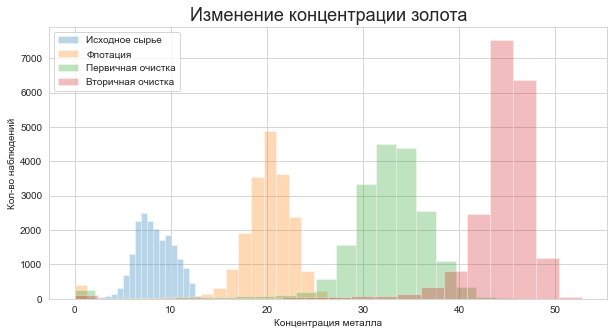

In [27]:
show_hists(au_data, 'Изменение концентрации золота')

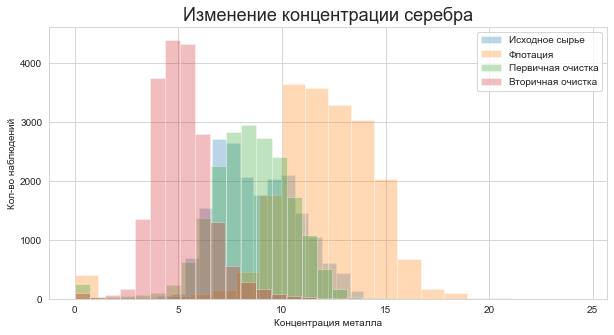

In [28]:
show_hists(ag_data, 'Изменение концентрации серебра')

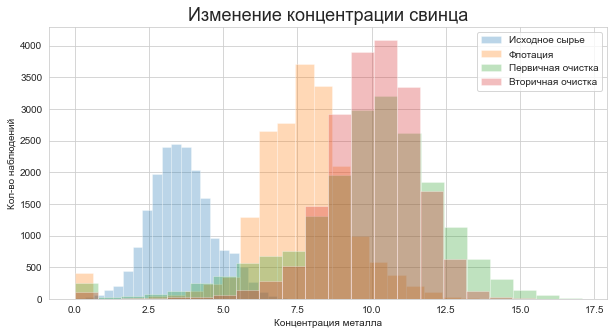

In [29]:
show_hists(pb_data, 'Изменение концентрации свинца')

По графикам можем определить, что для разных металлов концентрация на различных этапах очистки отличается:
* Концентрация золота увеличивается с каждым этапом. 
* Концентрация серебра после флотации с каждым следующим этапом падает. 
* У свинца результаты первичной и вторичной очистки почти идентичны.

### 2.2 Сравнение распределений размеров гранул сырья

У нас есть два признака с параметром `feed_size` в обучающей и тестовой выборках - `'rougher.input.feed_size'` и `'primary_cleaner.input.feed_size'`. С помощью гистограммы cравним их распределения. Если они сильно отличаются друг от друга, оценка модели будет неправильной.

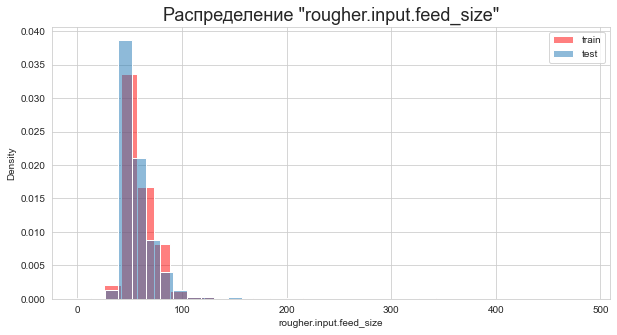

In [30]:
f, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Распределение "rougher.input.feed_size"', fontsize=18)
sns.histplot(train['rougher.input.feed_size'], bins=30, stat='density',alpha=.5, color='r')
sns.histplot(test['rougher.input.feed_size'], bins=30, stat='density', alpha=.5)
ax.legend(['train', 'test'])
plt.show()

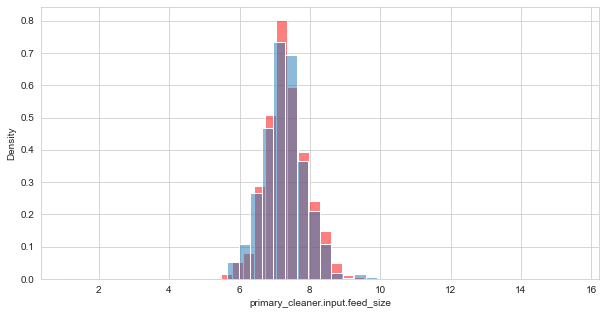

In [31]:
f, axes = plt.subplots(figsize=(10, 5))
ax.set_title('Распределение "primary_cleaner.input.feed_size"', fontsize=18)
sns.histplot(train['primary_cleaner.input.feed_size'], bins=30, stat='density',alpha=.5, color='r')
sns.histplot(test['primary_cleaner.input.feed_size'], bins=30, stat='density', alpha=.5)
ax.legend(['train', 'test'])
plt.show()

* Судя по графику, значения в обеих выборках не сильно отличаются. 
* Признак "Размер гранул сырья" можно использовать для обучения модели.

### 2.3 Исследование суммарных концентраций веществ

Рассчитаем суммарные концентрации веществ на разных стадиях (в сырье, после флотации и в финальном концентрате после двух этапов очистки).

In [32]:
full['feed_conc'] = full['rougher.input.feed_ag'] + full['rougher.input.feed_pb'] +\
            full['rougher.input.feed_sol'] + full['rougher.input.feed_au']
full['rougher_conc'] = full['rougher.output.concentrate_ag'] + full['rougher.output.concentrate_pb'] +\
            full['rougher.output.concentrate_sol'] + full['rougher.output.concentrate_au']
full['final_conc'] = full['final.output.concentrate_ag'] + full['final.output.concentrate_pb'] +\
            full['final.output.concentrate_sol'] + full['final.output.concentrate_au']

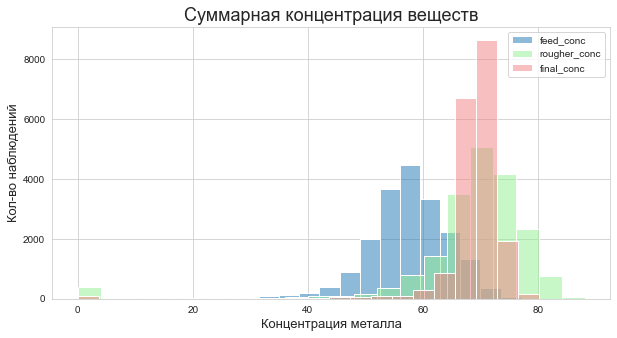

In [33]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_ylabel('Кол-во наблюдений', fontsize=13)
ax.set_xlabel('Концентрация металла', fontsize=13)
ax.set_title('Суммарная концентрация веществ', size=18)
sns.histplot(full['feed_conc'], alpha=.5, bins=22)
sns.histplot(full['rougher_conc'], alpha=.5, color='lightgreen', bins=22)
sns.histplot(full['final_conc'], alpha=.5, color='lightcoral', bins=22)
ax.legend(['feed_conc', 'rougher_conc', 'final_conc'])
plt.show()

По графикам видим, что в суммарных данных много нулевых или близких к нулю значений. Нужно избавиться от наблюдений с такими аномалиями, чтобы они не повлияли на качество модели.

In [34]:
before_len = len(train)
train = train.loc[(full['feed_conc'] > 0) &
                  (full['rougher_conc'] > 0) &
                  (full['final_conc'] > 0)]

print("Удалено {} объектов".format(before_len - len(train)))

Удалено 741 объектов


**Выводы**

* Проанализированы концентрации металлов (Au, Ag, Pb) на всех стадиях очистки на полной выборке. Выявлены аномалии (резкий спад концентраций до 0).
* Рассмотрены распределения гранул сырья на входе технологического процесса для обучающей и тестовой выборок. Графики показали, что распределения не сильно отличаются друг от друга.
* Анализ суммарных концентраций подтвердил наличие аномальных данных. Все объекты с суммарной концентрацией смеси равной 0 были удалены из тренировочной выборки. Всего удален 741 объект (5% данных).

## 3. Модель

### 3.1 Функция итоговой sMAPE

Напишем функции для вычисления метрики качества final_smape (финальное симметричное среднее абсолютное процентное отклонение)

In [35]:
def smape(target, predict):
    return 1 / len(target) * sum( abs(target - predict) / ( (abs(target) + abs(predict)) * 0.5) ) * 100

In [36]:
def final_smape(smape_r, smape_f):
    return 0.25 * smape_r + 0.75 * smape_f

### 3.2 Обучение и оценка качества моделей
* Финальная метрика final_smape зависит линейно от smape после флотации и после очистки. Максимизировав их обе отдельно, сможем добиться максимума финальной метрики. Так что обучать и валидировать модели можно независимо друг от друга.
* Выделим в обучающей выборке признаки и целевые признаки

In [37]:
X_r = train[model_r_columns]
X_f = train[model_f_columns]
y_r = train['rougher.output.recovery']
y_f = train['final.output.recovery']
test_r = test[model_r_columns]
test_f = test[model_f_columns]

* Масштабируем признаки на обучающей и тестовой выборках с помощью метода `StandardScaler`.

In [38]:
scaler = StandardScaler()

scaler.fit(X_r)
X_r = scaler.transform(X_r)

scaler.fit(X_f)
X_f = scaler.transform(X_f)

In [39]:
import warnings
warnings.filterwarnings("ignore")

---

* Модель **Линейная регресия**

In [40]:
# инициализируем модель
model_lr_r = LinearRegression()

# Обучим модель для этапа флотации
smape_model_lr_r = cross_val_score(model_lr_r, X_r, y_r, 
                                   scoring = make_scorer(smape),
                                   cv = 5,
                                   n_jobs = -1).mean()

In [41]:
model_lr_f = LinearRegression()

# Обучим модель для финального этапа
smape_model_lr_f = cross_val_score(model_lr_f, X_f, y_f, 
                                   scoring = make_scorer(smape),
                                   cv = 5,
                                   n_jobs = -1).mean()

In [42]:
print('Линейная регрессия:')
print('    sMAPE rougher: {:.2f} %'.format(smape_model_lr_r))
print('    sMAPE cleaner: {:.2f} %'.format(smape_model_lr_f))
print('Final sMAPE: {:.2f} %'.format(final_smape(smape_model_lr_r, smape_model_lr_f)))

Линейная регрессия:
    sMAPE rougher: 6.28 %
    sMAPE cleaner: 9.48 %
Final sMAPE: 8.68 %


---

* Модель **Дерево решений**

In [43]:
param_grid = {'max_depth': range(1, 11),
              'min_samples_split': range(1, 6),
              'min_samples_leaf': range(1, 4)}

# инициализируем модель
model_dt_r = DecisionTreeRegressor()

# инициализируем GridSearchCV
grid_search_r = GridSearchCV(estimator = model_dt_r, 
                             param_grid = param_grid, 
                             cv = 5, 
                             n_jobs = -1,  
                             scoring = make_scorer(smape, greater_is_better=False))
grid_search_r.fit(X_r, y_r)

print(grid_search_r.best_params_)
print('    sMAPE rougher: {:.2f} %'.format(grid_search_r.best_score_))

{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 5}
    sMAPE rougher: -6.54 %


In [44]:
# инициализируем модель
model_dt_f = DecisionTreeRegressor()

# инициализируем GridSearchCV
grid_search_f = GridSearchCV(estimator = model_dt_f, 
                             param_grid = param_grid, 
                             cv = 5, 
                             n_jobs = -1,  
                             scoring = make_scorer(smape, greater_is_better=False))
grid_search_f.fit(X_f, y_f)

print(grid_search_f.best_params_)
print('    sMAPE rougher: {:.2f} %'.format(grid_search_f.best_score_))

{'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}
    sMAPE rougher: -9.52 %


In [45]:
print('Дерево решений:')
print('    sMAPE rougher: {:.2f} %'.format(grid_search_r.best_score_))
print('    sMAPE cleaner: {:.2f} %'.format(grid_search_f.best_score_))
print('Final sMAPE: {:.2f} %'.format(final_smape(grid_search_r.best_score_, grid_search_f.best_score_)))

Дерево решений:
    sMAPE rougher: -6.54 %
    sMAPE cleaner: -9.52 %
Final sMAPE: -8.78 %


---

* Модель **Случайный лес**

In [46]:
param_grid = {'n_estimators': range(1, 11, 2),
              'max_depth': range(1, 6),
              'min_samples_split': range(1, 4),
              'min_samples_leaf': range(1, 4)}

# инициализируем модель
model_rf_r = RandomForestRegressor()

# инициализируем GridSearchCV
grid_search_r = GridSearchCV(estimator = model_rf_r, 
                             param_grid = param_grid, 
                             cv = 5, 
                             n_jobs = -1,  
                             scoring = make_scorer(smape, greater_is_better=False))
grid_search_r.fit(X_r, y_r)

print(grid_search_r.best_params_)
print('    sMAPE rougher: {:.2f} %'.format(grid_search_r.best_score_))

{'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 5}
    sMAPE rougher: -6.17 %


In [47]:
# инициализируем модель
model_rf_f = RandomForestRegressor()

# инициализируем GridSearchCV
grid_search_f = GridSearchCV(estimator = model_rf_f, 
                             param_grid = param_grid, 
                             cv = 5, 
                             n_jobs = -1,  
                             scoring = make_scorer(smape, greater_is_better=False))
grid_search_f.fit(X_f, y_f)

print(grid_search_f.best_params_)
print('    sMAPE rougher: {:.2f} %'.format(grid_search_f.best_score_))

{'max_depth': 1, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 7}
    sMAPE rougher: -9.48 %


In [48]:
print('Случайный лес:')
print('    sMAPE rougher: {:.2f} %'.format(grid_search_r.best_score_))
print('    sMAPE cleaner: {:.2f} %'.format(grid_search_f.best_score_))
print('Final sMAPE: {:.2f} %'.format(final_smape(grid_search_r.best_score_, grid_search_f.best_score_)))

Случайный лес:
    sMAPE rougher: -6.17 %
    sMAPE cleaner: -9.48 %
Final sMAPE: -8.65 %


---

* Модель **Lasso**

In [49]:
model_ls_r = Lasso(alpha=0.2)
# Обучим модель для финального этапа
smape_ls_r = cross_val_score(model_ls_r, X_r, y_r, 
                             scoring = make_scorer(smape),
                             cv = 5,
                             n_jobs = -1).mean()
smape_ls_r

6.284899361592912

In [50]:
model_ls_f = Lasso(alpha=0.4)
# Обучим модель для финального этапа
smape_ls_f = cross_val_score(model_ls_f, X_f, y_f, 
                             scoring = make_scorer(smape),
                             cv = 5,
                             n_jobs = -1).mean()
smape_ls_f

9.029458882336177

In [51]:
print('Модель Lasso:')
print('    sMAPE rougher: {:.2f} %'.format(smape_ls_r))
print('    sMAPE cleaner: {:.2f} %'.format(smape_ls_f))
print('Final sMAPE: {:.2f} %'.format(final_smape(smape_ls_r, smape_ls_f)))

Модель Lasso:
    sMAPE rougher: 6.28 %
    sMAPE cleaner: 9.03 %
Final sMAPE: 8.34 %


---

* Модель **Ridge**

In [52]:
model_rg_r = RidgeCV()
# Обучим модель для финального этапа
smape_rg_r = cross_val_score(model_rg_r, X_r, y_r, 
                             scoring = make_scorer(smape),
                             cv = 5,
                             n_jobs = -1).mean()
smape_rg_r

6.274631088068675

In [53]:
model_rg_f = RidgeCV()
# Обучим модель для финального этапа
smape_rg_f = cross_val_score(model_rg_f, X_f, y_f, 
                             scoring = make_scorer(smape),
                             cv = 5,
                             n_jobs = -1).mean()
smape_rg_f

9.476534414345005

In [54]:
print('Модель Ridge:')
print('    sMAPE rougher: {:.2f} %'.format(smape_rg_r))
print('    sMAPE cleaner: {:.2f} %'.format(smape_rg_f))
print('Final sMAPE: {:.2f} %'.format(final_smape(smape_rg_r, smape_rg_f)))

Модель Ridge:
    sMAPE rougher: 6.27 %
    sMAPE cleaner: 9.48 %
Final sMAPE: 8.68 %


---

* Модель **Elastic-Net**

Подберём гиперпараметры для модели с помощью техники `GridSearchCV` библиотеки `sklearn`. Она последовательно обучает модель на всех заданных комбинациях гиперпараметров, используя кросс валидацию. Далее возвращает комбинацию гиперпараметров, с которыми модель достигла наилучшего значения метрики качества.

In [55]:
l1_ratios = np.linspace(0, 1, 10, endpoint=True)
alphas = np.linspace(0.1, 1, 10, endpoint=True)
param_grid = {'l1_ratio': l1_ratios,
              'alpha': alphas}

# инициализируем модель ElasticNet
model_en_r = ElasticNet()

# инициализируем GridSearchCV
grid_search_r = GridSearchCV(estimator = model_en_r, 
                             param_grid = param_grid, 
                             cv = 5, 
                             n_jobs = -1,  
                             scoring = make_scorer(smape, greater_is_better=False))
grid_search_r.fit(X_r, y_r)

print(grid_search_r.best_params_)
print('    sMAPE rougher: {:.2f} %'.format(grid_search_r.best_score_))

{'alpha': 0.4, 'l1_ratio': 0.0}
    sMAPE rougher: -6.08 %


In [56]:
# инициализируем модель ElasticNet
model_en_f = ElasticNet()

# инициализируем GridSearchCV
grid_search_f = GridSearchCV(estimator = model_en_f, 
                             param_grid = param_grid, 
                             cv = 5, 
                             n_jobs = -1,  
                             scoring = make_scorer(smape, greater_is_better=False))
grid_search_f.fit(X_f, y_f)

print(grid_search_f.best_params_)
print('    sMAPE cleaner:   {:.2f} %'.format(grid_search_f.best_score_))

{'alpha': 1.0, 'l1_ratio': 0.0}
    sMAPE cleaner:   -8.81 %


In [57]:
print('ElasticNet:')
print('    sMAPE rougher: {:.2f} %'.format(grid_search_r.best_score_))
print('    sMAPE cleaner: {:.2f} %'.format(grid_search_f.best_score_))
print('Final sMAPE: {:.2f} %'.format(final_smape(grid_search_r.best_score_, grid_search_f.best_score_)))

ElasticNet:
    sMAPE rougher: -6.08 %
    sMAPE cleaner: -8.81 %
Final sMAPE: -8.13 %


---

* Модель **CatBoostRegressor**

In [58]:
model_cat_r = CatBoostRegressor(silent=True)

smape_cat_r = cross_val_score(model_cat_r, X_r, y_r, 
                             scoring = make_scorer(smape),
                             cv = 5,
                             n_jobs = -1).mean()
smape_cat_r

6.508187600274148

In [61]:
param_grid = {'learning_rate': [0.01, 0.03],
              'depth': [2, 4, 6],
              'l2_leaf_reg': [3, 5, 7],
              'iterations': [200, 500],
              'early_stopping_rounds': range(10, 30, 10), 
              'loss_function': ['MAE']}

# инициализируем модель CatBoostRegressor
model_cat_r = CatBoostRegressor(silent=True)

# инициализируем GridSearchCV
grid_search_r = GridSearchCV(estimator = model_cat_r, 
                             param_grid = param_grid, 
                             cv = 5, 
                             n_jobs = -1,  
                             scoring = make_scorer(smape, greater_is_better=False))
grid_search_r.fit(X_r, y_r)

print(grid_search_r.best_params_)
print('    sMAPE rougher:   {:.2f} %'.format(grid_search_r.best_score_))

{'depth': 4, 'early_stopping_rounds': 10, 'iterations': 200, 'l2_leaf_reg': 7, 'learning_rate': 0.03, 'loss_function': 'MAE'}
    sMAPE rougher:   -5.68 %


In [62]:
# инициализируем модель CatBoostRegressor
model_cat_f = CatBoostRegressor(silent=True)

# инициализируем GridSearchCV
grid_search_f = GridSearchCV(estimator = model_cat_r, 
                             param_grid = param_grid, 
                             cv = 5, 
                             n_jobs = -1, 
                             scoring = make_scorer(smape, greater_is_better=False))
grid_search_f.fit(X_f, y_f)

print(grid_search_f.best_params_)
print('    sMAPE rougher:   {:.2f} %'.format(grid_search_f.best_score_))

{'depth': 6, 'early_stopping_rounds': 10, 'iterations': 500, 'l2_leaf_reg': 5, 'learning_rate': 0.01, 'loss_function': 'MAE'}
    sMAPE rougher:   -8.76 %


In [63]:
print('CatBoostRegressor:')
print('    sMAPE rougher: {:.2f} %'.format(grid_search_r.best_score_))
print('    sMAPE cleaner: {:.2f} %'.format(grid_search_f.best_score_))
print('Final sMAPE: {:.2f} %'.format(final_smape(grid_search_r.best_score_, grid_search_f.best_score_)))

CatBoostRegressor:
    sMAPE rougher: -5.68 %
    sMAPE cleaner: -8.76 %
Final sMAPE: -7.99 %


* Лучшее качество метрики показала модель `CatBoostRegressor`, будем использовать её.

### 3.3 Тестирование модели

Проверим качество модели на тестовой выборке.

In [64]:
# из исходных данных сохраним целевые признаки для тестовой выборки
y_test_r = full.loc[test.index, 'rougher.output.recovery']
y_test_f = full.loc[test.index, 'final.output.recovery']

In [65]:
# масштабируем признаки тестовой выборки 
scaler = StandardScaler()

scaler.fit(X_r)
test_r = scaler.transform(test_r)

scaler.fit(X_f)
test_f = scaler.transform(test_f)

In [66]:
# Инициализируем модели CatBoostRegressor с подобранными ранее параметрами
model_r = CatBoostRegressor(iterations=200, 
                            loss_function='MAE', 
                            early_stopping_rounds=10, 
                            silent=True, 
                            depth=4, 
                            l2_leaf_reg=7, 
                            learning_rate=0.03)
model_f = CatBoostRegressor(iterations=500, 
                            loss_function='MAE', 
                            early_stopping_rounds=10, 
                            silent=True, 
                            depth=6, 
                            l2_leaf_reg=5, 
                            learning_rate=0.01)

# Обучене моделей и получение предсказаний
model_r.fit(X_r, y_r)
model_f.fit(X_f, y_f)
predict_r = model_r.predict(test_r)
predict_f = model_f.predict(test_f)

print('sMAPE флотации на тестовой выборке: {:.2f} %'.format(smape(y_test_r, predict_r)))
print('sMAPE очистки на тестовой выборке:  {:.2f} %'.format(smape(y_test_f, predict_f)))
smape_fin = final_smape(smape(y_test_r, predict_r), smape(y_test_f, predict_f))
print('Итоговая sMAPE на тестовой выборке: {:.2f} %'.format(smape_fin))

sMAPE флотации на тестовой выборке: 8.84 %
sMAPE очистки на тестовой выборке:  10.24 %
Итоговая sMAPE на тестовой выборке: 9.89 %


* Полученное итоговое значение sMAPE на тестовой выборке **(9.89 %)** выше, чем на обучающей **(7.99 %)**
* Сравним полученную модель с константной. Для этого будем использовать модель `DummyRegressor`.

In [67]:
dummy_r = DummyRegressor(strategy = 'mean')
dummy_f = DummyRegressor(strategy = 'mean')

dummy_r.fit(X_r, y_r)
dummy_pred_r = dummy_r.predict(test_r)

dummy_f.fit(X_f, y_f)
dummy_pred_f = dummy_f.predict(test_f)

In [68]:
print('Константная модель')
print('sMAPE флотации на тестовой выборке: {:.2f} %'.format(smape(y_test_r, dummy_pred_r)))
print('sMAPE очистки на тестовой выборке:  {:.2f} %'.format(smape(y_test_f, dummy_pred_f)))
smape_dummy = final_smape(smape(y_test_r, dummy_pred_r), smape(y_test_f, dummy_pred_f))
print('Итоговая sMAPE на тестовой выборке: {:.2f} %'.format(smape_dummy))

Константная модель
sMAPE флотации на тестовой выборке: 8.92 %
sMAPE очистки на тестовой выборке:  9.90 %
Итоговая sMAPE на тестовой выборке: 9.65 %


* Метрика sMAPE на обученной модели на **0.24 % выше**, чем на константной модели.

**Выводы**

* Данные обучены на моделях линейной регрессии, `ElasticNet` и `CatBoostRegressor`.
* Отдельно оптимизировались модели для эффекивности обогащения после флотации и после очистки.
* Применены техники кросс-валидации для оценки качества моделей и `GridSearchCV` для поиска оптимальных гиперпараметров.
* Лучший результат дала модель `CatBoostRegressor`.
* sMAPE на обучающей выборке:
    * sMAPE флотация: 5.68 %
    * sMAPE очистка: 8.76 %
    * sMAPE итоговое: 7.99 %
* sMAPE на тестовой выборке:
    * sMAPE флотация: 8.84 %
    * sMAPE очистка: 10.24 %
    * sMAPE итоговое: **9.89 %**
* Итоговое sMAPE на константной модели 9.65 %

## 4. Общий вывод

**1)**

* Данные успешно проанализированы. Показатель эффективности обогащения рассчитан корректно.
* Отобраны признаки, избыточные и нерелевантные для модели (некоторые параметры, характеризующие текущее состояние этапов технологического процесса).
* Для актуальных признаков были заполнены пропуски на основе имеющихся исторических данных.

**2)**

* Проанализированы концентрации металлов (Au, Ag, Pb), а также суммарные концентрации веществ на всех стадиях очистки.
* Рассмотрены распределения гранул сырья на входе технологического процесса для обучающей и тестовой выборок. Графики показали, что распределения не сильно отличаются друг от друга.
* Анализ суммарных концентраций подтвердил наличие аномальных данных. Все объекты с суммарной концентрацией смеси равной 0 были удалены из тренировочной выборки. Всего удален 741 объект (5% данных).

**3)**

* Данные обучены на моделях линейной регрессии, `ElasticNet` и `CatBoostRegressor`.
* Отдельно оптимизировались модели для эффекивности обогащения после флотации и после очистки.
* Применены техники кросс-валидации для оценки качества моделей и `GridSearchCV` для поиска оптимальных гиперпараметров.
* sMAPE на тестовой выборке (модель `CatBoostRegressor`):
    * sMAPE флотация: 8.84 %
    * sMAPE очистка: 10.24 %
    * sMAPE итоговое: **9.89 %**
* Метрика sMAPE на обученной модели на **0.24 % выше**, чем на константной модели.